<a href="https://colab.research.google.com/github/heromiya/GEE-LCM/blob/master/Landcover_using_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
ee.Authenticate()
ee.Initialize(project='ee-heromiya')

In [1]:
import os
import glob
import shutil
import time
import json
from pprint import pprint

import numpy as np
import tensorflow as tf
import folium

from osgeo import gdal
from osgeo import osr
import matplotlib.pyplot as plt

2024-01-15 09:26:50.813814: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def reduce_class_value(feat):
  return feat.set('class', ee.Number(feat.get('class')).subtract(1))

def cloudMask(img):
  return img.updateMask(img.select('BQA').lt(64))

def select_landsat(year):
  if (year >= 2013):
    return {
        'bands': ['B2', 'B3', 'B4', 'B5', 'B6', 'B7'],
        'FCCbands': ['B5', 'B4', 'B3'],
        'TextureBand': ['B5'],
        'bandsClassify': ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','B5_1'],
        'Landsat': 'LANDSAT/LC08/C01/T1'
    }

  if (year >= 1999 and year <= 2002):
    return {
        'bands': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7'],
        'TextureBand': ['B4'],
        'bandsClassify': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7','B4_1'],
        'FCCbands': ['B4', 'B3', 'B2'],
        'Landsat': 'LANDSAT/LE07/C01/T1'
    }

  if (year >= 1984 and year <= 1998 or year >=2003 and year <=2012):
    return{
        'bands': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7'],
        'bandsClassify': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7','B4_1'],
        'FCCbands': ['B4', 'B3', 'B2'],
        'TextureBand': ['B4'],
        'Landsat': 'LANDSAT/LT05/C01/T1'
    }
  
  if (year == 1983):
    return{
        'bands': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7'],
        'bandsClassify': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7','B4_1'],
        'FCCbands': ['B4', 'B3', 'B2'],
        'TextureBand': ['B4'],
        'Landsat': 'LANDSAT/LT04/C01/T1'
    }
  
  if (year >= 1979 and year <= 1982):
    return {
        'bands':         ['B4_median', 'B5_median', 'B6_median','B7_median'],
        'bandsClassify': ['B4_median', 'B5_median', 'B6_median','B7_median','B6_median_1'],
        'FCCbands':      ['B6_median', 'B5_median', 'B4_median'],
        'TextureBand':   ['B6_median'],
        'Landsat': 'LANDSAT/LM03/C01/T1'
    }

  if (year >= 1975 and year <= 1978):
    return {
        'bands':         ['B4_median', 'B5_median', 'B6_median','B7_median'],
        'bandsClassify': ['B4_median', 'B5_median', 'B6_median','B7_median','B6_median_1'],
        'FCCbands':      ['B6_median', 'B5_median', 'B4_median'],
        'TextureBand':   ['B6_median'],
        'Landsat': 'LANDSAT/LM02/C01/T2'
    }

  if (year >= 1972 and year <= 1974):
    return {
        'bands':         ['B4_median', 'B5_median', 'B6_median','B7_median'],
        'bandsClassify': ['B4_median', 'B5_median', 'B6_median','B7_median','B6_median_1'],
        'FCCbands':      ['B6_median', 'B5_median', 'B4_median'],
        'TextureBand':   ['B6_median'],
        'Landsat': 'LANDSAT/LM01/C01/T2'
    }

In [3]:
def landsat_product(landsat_params):
  landsat_id = landsat_params['Landsat']
  if(landsat_id == 'LANDSAT/LM01/C01/T2' or landsat_id == 'LANDSAT/LM02/C01/T2' or landsat_id == 'LANDSAT/LM03/C01/T1'):
    image = ee.ImageCollection(landsat_id).filterDate(str(gtYearBegin) + '-01-01',str(gtYearEnd) + '-12-31').filter(ROI[roi]['doyFilterLandsat']).filterBounds(out_ext).filterMetadata('CLOUD_COVER_LAND', 'less_than', 20).map(cloudMask).reduce(ee.Reducer.median())
    return {
      'region': image.geometry().bounds().getInfo(),
      'image': image,
      'image_int': image.toByte()       
    }
  else:
    image_col = ee.ImageCollection(landsat_id).filterDate(str(gtYearBegin) + '-01-01',str(gtYearEnd) + '-12-31').filter(ROI[roi]['doyFilterLandsat']).filterBounds(out_ext)
    return {
      'region': image_col.geometry().bounds().getInfo(),
      'image': ee.Algorithms.Landsat.simpleComposite(image_col, 50, cloud, 40, True).select(landsat_params['bands']),
      'image_int': ee.Algorithms.Landsat.simpleComposite(image_col, 50, cloud, 40, False).select(landsat_params['bands'])
  }

In [4]:
def add_indices(params, product):
  L = params['Landsat']
  if(L =='LANDSAT/LC08/C01/T1'):
    swir  = product['image'].select('B6')
    nir   = product['image'].select('B5')
    red   = product['image'].select('B4')
    green = product['image'].select('B3')

  if(L == 'LANDSAT/LE07/C01/T1'):
    swir  = product['image'].select('B5')
    nir   = product['image'].select('B4')
    red   = product['image'].select('B3')
    green = product['image'].select('B2')

  if(L == 'LANDSAT/LM04/C01/T1' or L == 'LANDSAT/LT05/C01/T1'):
    swir  = product['image'].select('B5')
    nir   = product['image'].select('B4')
    red   = product['image'].select('B3')
    green = product['image'].select('B2')

  ndvi  = nir.subtract(red).divide(nir.add(red))
  ndbi  = swir.subtract(nir).divide(swir.add(nir))
  bi    = ndbi.subtract(ndvi)
  ndwi  = green.subtract(swir).divide(green.add(swir))

  product['image'] = product['image'].addBands([ndvi, ndbi, bi, ndwi])
  product['image'] = product['image'].rename(ee.List(params['bands'] + ['ndvi','ndbi','bi','ndwi']))
  params['bandsClassify'].extend(['ndvi', 'ndbi', 'bi', 'ndwi'])

def add_indices_mss(params, product):
  nir = product['image'].select('B6_median')
  red = product['image'].select('B5_median')
  ndvi = nir.subtract(red).divide(nir.add(red))

  product['image'] = product['image'].addBands(ndvi)
  product['image'] = product['image'].rename(ee.List(params['bands'] + ['ndvi']))
  params['bandsClassify'].append('ndvi')
  

In [7]:
##### User defined paramters ######
import ee
ee.Authenticate()
ee.Initialize(project='ee-heromiya')

ts = time.time()
timestamp = int(ts)

cloud = 30
spatial_resolution = 30
n_sample = 10000
distance = 370000

kernel_size_list = [1, 3, 5, 7, 9]

base_distance = 5000
patch_size = 256
buffer_distance = base_distance * (round((spatial_resolution * 0.5 * patch_size)/base_distance) +1)

USER_NAME = 'heromiya'
GT_DATA = 'projects/ee-heromiya/assets/gt-pt-bkk-240115'

ROI = [
       {'cityName': 'Bangkok2', 'LatMax': 14.2206, 'LatMin': 13.4323, 'LonMax': 101.3378, 'LonMin': 99.8742, 'yearBegin':1998, 'yearEnd':2002, 
        'doyFilter':ee.Filter.And(ee.Filter.greaterThanOrEquals('doy',  1), ee.Filter.lessThanOrEquals('doy',  366)), 
        'doyFilterLandsat': ee.Filter.dayOfYear(1,366)},
]

MY_DRIVE_PATH = '/content/drive/MyDrive'
SHARED_DRIVE_PATH = '/content/drive/Shareddrives/Miyazaki Lab./' + USER_NAME + '/'
OUTPUT_ASSET_ID = 'users/' + USER_NAME + '/demo'

In [8]:
roi= ''
out_ext = ''

for roi in range(0, len(ROI), 1):
  city_name = ROI[roi]['cityName']
  year_begin = ROI[roi]['yearBegin']
  year_end = ROI[roi]['yearEnd']

  IMAGE_FILE_PREFIX = city_name + '_' + str(year_begin) + '_' + str(year_end)
  FOLDER_NAME = USER_NAME + '_' + IMAGE_FILE_PREFIX + '_' + str(timestamp)
  FOLDER_PATH = MY_DRIVE_PATH + '/' + FOLDER_NAME
  TRAIN_FILE_PREFIX = 'Training_' + str(timestamp)
  TEST_FILE_PREFIX = 'Testing_' + str(timestamp)

  file_extension = '.tfrecord.gz'
  TRAIN_FILE_PATH =  MY_DRIVE_PATH + '/' + FOLDER_NAME + '/sample/' +TRAIN_FILE_PREFIX + file_extension
  TEST_FILE_PATH = MY_DRIVE_PATH + '/' + FOLDER_NAME + '/sample/' + TEST_FILE_PREFIX + file_extension

  OUTPUT_IMAGE_TFR = MY_DRIVE_PATH + '/' + FOLDER_NAME + '/'+ IMAGE_FILE_PREFIX+'.TFRecord'
  OUTPUT_IMAGE_TIF = MY_DRIVE_PATH + '/' + FOLDER_NAME + '/'+ IMAGE_FILE_PREFIX+'.tif'

  for year in range(year_begin, year_end+1, 1):
    nSampleClass = []
    out_ext = ee.Geometry.Rectangle([ ROI[roi]['LonMin'], ROI[roi]['LatMin'], ROI[roi]['LonMax'], ROI[roi]['LatMax']])
    EXPORT_REGION = out_ext
    out_ext_center = out_ext.centroid()

    out_ext_buffer = out_ext.buffer(buffer_distance).bounds()

    center_lat = out_ext_center.getInfo()['coordinates'][1]
    center_lon = out_ext_center.getInfo()['coordinates'][0]

    landsat_params = select_landsat(year_begin)

    gtYearBegin = year_begin
    gtYearEnd = year_end

    product = landsat_product(landsat_params)

    ref_point = ee.FeatureCollection(GT_DATA).map(reduce_class_value)
    LABEL_DATA = ref_point.filter(ee.Filter.And(ee.Filter.greaterThanOrEquals('year', gtYearBegin), ee.Filter.lessThanOrEquals('year', gtYearEnd), ROI[roi]['doyFilter']))
    LABEL_DATA = LABEL_DATA.filterBounds(product['region'])
    if (year_end > 1982):
      add_indices(landsat_params, product)
    else:
      add_indices_mss(landsat_params, product)

    gt_image = product['image']
    gt_image_texture = product['image_int']
    for i in kernel_size_list:
      gt_image_texture = gt_image.addBands(product['image_int'].select(landsat_params['TextureBand']).entropy(ee.Kernel.gaussian(i)))


    out_image = product['image'].clip(out_ext_buffer)
    out_image_texture = product['image_int'].clip(out_ext_buffer)
    for i in kernel_size_list:
      out_image_texture = out_image.addBands(product['image_int'].clip(out_ext_buffer).select(landsat_params['TextureBand']).entropy(ee.Kernel.gaussian(i)))

In [9]:
print(gt_image.getInfo())

{'type': 'Image', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B7', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'ndvi', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'ndbi', 'data_type': {'type': 'PixelType', 'precision': 'flo

In [10]:
BANDS = landsat_params['bandsClassify']
LABEL = 'class'
N_CLASSES = 4

FEATURE_NAMES = list(BANDS)
FEATURE_NAMES.append(LABEL)

sample = gt_image_texture.sampleRegions(
    collection = LABEL_DATA,
    properties = [LABEL],
    scale = spatial_resolution,
).randomColumn()

training = sample.filter(ee.Filter.lt('random', 0.8))
testing = sample.filter(ee.Filter.gte('random', 0.8))

#pprint({'training': training.first().getInfo()})
#pprint({'testing': testing.first().getInfo()})

In [11]:
training_task = ee.batch.Export.table.toDrive(
  collection=training,
  description='Training Export',
  folder=FOLDER_NAME,
  fileNamePrefix=TRAIN_FILE_PREFIX,
  fileFormat='TFRecord',
  selectors=FEATURE_NAMES)

testing_task = ee.batch.Export.table.toDrive(
  collection=testing,
  description='Testing Export',
  folder=FOLDER_NAME,
  fileNamePrefix=TEST_FILE_PREFIX,
  fileFormat='TFRecord',
  selectors=FEATURE_NAMES)

In [12]:
training_task.start()
testing_task.start()

In [13]:
while training_task.active():
  print('Polling for task (id: {}).'.format(training_task.id))
  time.sleep(20)
print('Done with training export.')

while testing_task.active():
  print('Polling for task (id: {}).'.format(testing_task.id))
  time.sleep(20)
print('Done with testing export.')

Polling for task (id: G4L64576PKOPH5HPSDRMUJNB).
Polling for task (id: G4L64576PKOPH5HPSDRMUJNB).
Done with training export.
Done with testing export.


In [ ]:
src_dir = MY_DRIVE_PATH + '/' + FOLDER_NAME
src_files = os.listdir(src_dir)

dest_dir = os.path.join(src_dir, 'sample')

os.makedirs(dest_dir, exist_ok = True)

for file in src_files:
    shutil.move(os.path.join(src_dir, file), dest_dir)

In [ ]:
print('Found training file.' if tf.io.gfile.exists(TRAIN_FILE_PATH) 
    else 'No training file found.')

print('Found testing file.' if tf.io.gfile.exists(TEST_FILE_PATH) 
    else 'No testing file found.')

In [14]:
train_dataset = tf.data.TFRecordDataset('Training_1705311024.tfrecord.gz', compression_type='GZIP')
test_dataset = tf.data.TFRecordDataset('Testing_1705311024.tfrecord.gz', compression_type='GZIP')

# print(iter(train_dataset).next())
# print(iter(test_dataset).next())

In [15]:
columns = [
           tf.io.FixedLenFeature(shape=[1], dtype=tf.float32) for k in FEATURE_NAMES
]

features_dict = dict(zip(FEATURE_NAMES, columns))

pprint(features_dict)

{'B1': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'B2': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'B3': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'B4': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'B4_1': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'B5': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'B7': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'bi': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'class': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'ndbi': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'ndvi': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'ndwi': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None)}


In [16]:
def parse_tfrecord(example_proto):
  parsed_features = tf.io.parse_single_example(example_proto, features_dict)
  labels = parsed_features.pop(LABEL)
  return parsed_features, tf.cast(labels, tf.int32)

parsed_trainset = train_dataset.map(parse_tfrecord, num_parallel_calls=5)
parsed_testset = test_dataset.map(parse_tfrecord, num_parallel_calls=5)

# pprint(iter(parsed_trainset))
# pprint(iter(parsed_testset))

In [17]:
batch_size = 50

def to_tuple(inputs, label):
  return (tf.transpose(list(inputs.values())), tf.one_hot(indices=label, depth=N_CLASSES))

input_dataset = parsed_trainset.map(to_tuple).batch(batch_size)
validate_dataset = parsed_testset.map(to_tuple).batch(batch_size)


In [18]:
drop = 0.05
N_UNITS=64
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(N_UNITS, activation='relu'))
for i in range(8):
  model.add(tf.keras.layers.Dropout(drop))
  model.add(tf.keras.layers.Dense(N_UNITS, activation='relu'))

model.add(tf.keras.layers.Dense(N_CLASSES, activation=tf.nn.softmax))

In [20]:
import tensorflow_addons as tfa
optimizer = tfa.optimizers.RectifiedAdam()

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/home/jovyan/my-conda-envs/py310/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [23]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

log_d = './' #MY_DRIVE_PATH + '/' + FOLDER_NAME + '/' + 'model'
os.makedirs(log_d, exist_ok=True)

def build_callbacks():
    checkpointer = ModelCheckpoint(filepath = log_d + '/best_model.h5', verbose=0, save_best_only=True, monitor='val_loss')
    callbacks = [checkpointer]
    return callbacks
history = model.fit(x=input_dataset,validation_data=(validate_dataset), epochs=100, callbacks=build_callbacks())

Epoch 1/100
17/17 [==============================] - 3s 42ms/step - loss: 1.4000 - accuracy: 0.0654 - val_loss: 1.3885 - val_accuracy: 0.0957
Epoch 2/100
 1/17 [>.............................] - ETA: 0s - loss: 1.3479 - accuracy: 0.8000

/home/jovyan/my-conda-envs/py310/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 0s 14ms/step - loss: 1.3656 - accuracy: 0.2827 - val_loss: 1.3368 - val_accuracy: 0.9043
Epoch 3/100
17/17 [==============================] - 0s 17ms/step - loss: 1.3009 - accuracy: 0.8864 - val_loss: 1.2169 - val_accuracy: 0.9043
Epoch 4/100
17/17 [==============================] - 0s 16ms/step - loss: 1.1007 - accuracy: 0.8889 - val_loss: 0.8747 - val_accuracy: 0.9043
Epoch 5/100
17/17 [==============================] - 0s 16ms/step - loss: 0.6001 - accuracy: 0.8889 - val_loss: 0.3478 - val_accuracy: 0.9043
Epoch 6/100
17/17 [==============================] - 1s 91ms/step - loss: 0.3577 - accuracy: 0.8889 - val_loss: 0.3121 - val_accuracy: 0.9043
Epoch 7/100
17/17 [==============================] - 0s 15ms/step - loss: 0.3928 - accuracy: 0.8889 - val_loss: 0.2817 - val_accuracy: 0.9043
Epoch 8/100
17/17 [==============================] - 0s 16ms/step - loss: 0.3619 - accuracy: 0.8889 - val_loss: 0.2601 - val_accuracy: 0.9043
Epoch 9/100
17/17 

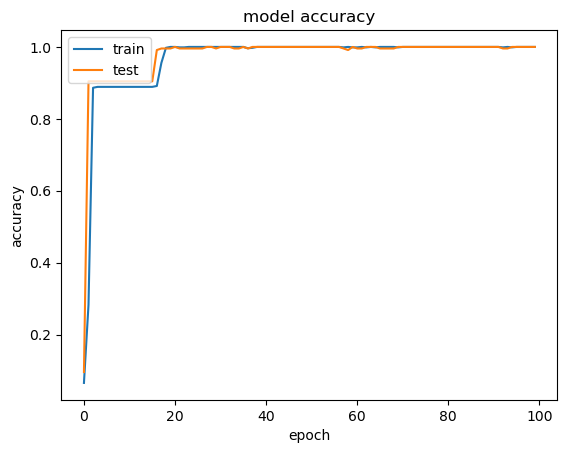

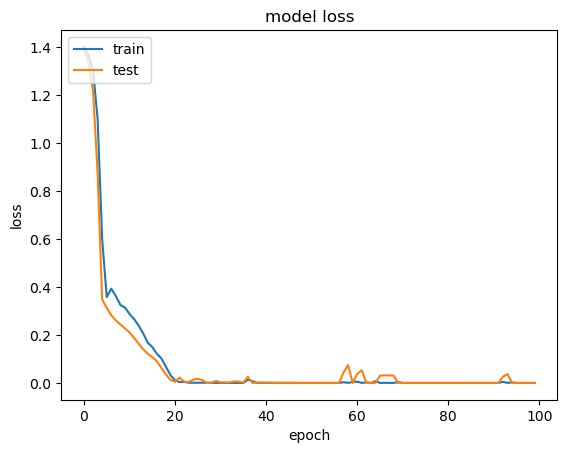

In [24]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
from tensorflow import keras
model = keras.models.load_model(log_d + '/best_model.h5')
model.evaluate(validate_dataset)

5/5 [==============================] - 0s 12ms/step - loss: 1.1288e-06 - accuracy: 1.0000


[1.128818098550255e-06, 1.0]

In [27]:
image_export_options = {
    'patchDimensions': [patch_size, patch_size],
    'maxFileSize': 104857600,
    'compressed': True
}

image_task = ee.batch.Export.image.toDrive(
  image=out_image_texture,
  description='Image Export',
  fileNamePrefix= IMAGE_FILE_PREFIX,
  folder= FOLDER_NAME,
  scale=spatial_resolution,
  fileFormat='TFRecord',
  region=out_ext_buffer,
  formatOptions=image_export_options,
)

image_task.start()

In [28]:
while image_task.active():
  print('Polling for task (id: {}).'.format(image_task.id))
  time.sleep(20)
print('Done with image export.')

Polling for task (id: 4PZVNOU6PSHBU34P3VT4K7CT).
Polling for task (id: 4PZVNOU6PSHBU34P3VT4K7CT).
Polling for task (id: 4PZVNOU6PSHBU34P3VT4K7CT).
Polling for task (id: 4PZVNOU6PSHBU34P3VT4K7CT).
Polling for task (id: 4PZVNOU6PSHBU34P3VT4K7CT).
Polling for task (id: 4PZVNOU6PSHBU34P3VT4K7CT).
Polling for task (id: 4PZVNOU6PSHBU34P3VT4K7CT).
Polling for task (id: 4PZVNOU6PSHBU34P3VT4K7CT).
Polling for task (id: 4PZVNOU6PSHBU34P3VT4K7CT).
Polling for task (id: 4PZVNOU6PSHBU34P3VT4K7CT).
Polling for task (id: 4PZVNOU6PSHBU34P3VT4K7CT).
Polling for task (id: 4PZVNOU6PSHBU34P3VT4K7CT).
Polling for task (id: 4PZVNOU6PSHBU34P3VT4K7CT).
Polling for task (id: 4PZVNOU6PSHBU34P3VT4K7CT).
Polling for task (id: 4PZVNOU6PSHBU34P3VT4K7CT).
Polling for task (id: 4PZVNOU6PSHBU34P3VT4K7CT).
Polling for task (id: 4PZVNOU6PSHBU34P3VT4K7CT).
Polling for task (id: 4PZVNOU6PSHBU34P3VT4K7CT).
Polling for task (id: 4PZVNOU6PSHBU34P3VT4K7CT).
Polling for task (id: 4PZVNOU6PSHBU34P3VT4K7CT).
Polling for task (id

In [ ]:
tfrecord_list = glob.glob(MY_DRIVE_PATH +'/' + FOLDER_NAME + '/' + '*.tfrecord.gz')
tfrecord_list.sort()
print(tfrecord_list)

json_list = glob.glob(MY_DRIVE_PATH +'/' + FOLDER_NAME + '/' + '*.json')
print(json_list)

In [ ]:
with open(json_list[0], "r") as read_file:
   mixer = json.load(read_file)

mixer

In [ ]:
patch_width = mixer['patchDimensions'][0]
patch_height = mixer['patchDimensions'][1]
patches = mixer['totalPatches']
patch_dimensions_flat = [patch_width*patch_height, 1]

image_columns = [
                tf.io.FixedLenFeature(shape=patch_dimensions_flat, dtype=tf.float32) for k in BANDS
]

image_features_dict = dict(zip(BANDS, image_columns))

image_dataset = tf.data.TFRecordDataset(tfrecord_list, compression_type='GZIP')


In [ ]:
def parse_image(example_proto):
  return tf.io.parse_single_example(example_proto, image_features_dict)

In [ ]:
image_dataset = image_dataset.map(parse_image, num_parallel_calls=5)

image_dataset = image_dataset.flat_map(
    lambda features: tf.data.Dataset.from_tensor_slices(features)
)

image_dataset = image_dataset.map(
  lambda data_dict: (tf.transpose(list(data_dict.values())), )
)

image_dataset = image_dataset.batch(patch_width * patch_height)

In [ ]:
predictions = model.predict(image_dataset, steps=patches, verbose=1)
print(predictions[0])

In [ ]:
writer = tf.io.TFRecordWriter(OUTPUT_IMAGE_TFR)

patch = [[]]
cur_patch = 1
for prediction in predictions:
  patch[0].append(tf.argmax(prediction, 1))

  if (len(patch[0])==patch_width*patch_height):
    print('Done with Patch ' + str(cur_patch) + ' of ' + str(patches) + '...')
    example = tf.train.Example(
        features=tf.train.Features(
            feature={
                'prediction': tf.train.Feature(
                    int64_list=tf.train.Int64List(
                        value=patch[0]
                    )
                )
            }
        )
    )

    writer.write(example.SerializeToString())
    patch=[[]]
    cur_patch +=1
  
writer.close()

In [ ]:
record_iterator = tf.compat.v1.python_io.tf_record_iterator(path=OUTPUT_IMAGE_TFR)

n_row = patches/mixer['patchesPerRow']
n_col = mixer['patchesPerRow']
current_row = 0
current_col = 0
counter = 0

for string_record in record_iterator:
  example = tf.train.Example()
  example.ParseFromString(string_record)
  values = np.array(example.features.feature['prediction'].int64_list.value).reshape(patch_width, patch_height).astype(np.int8)

  if (current_col==0):
    horizontal_strip = values
  else:
    horizontal_strip = np.concatenate([horizontal_strip, values], axis=1)
  current_col += 1

  if (current_col == n_col):
    if (current_row==0):
      image = horizontal_strip
    else:
      image = np.concatenate([image, horizontal_strip], axis=0)
      horizontal_strip = []

    current_row +=1
    current_col = 0
    print(counter)
  counter +=1
print(counter)

In [ ]:
imgplot = plt.imshow(image, cmap=plt.get_cmap('jet'), vmin=0, vmax=1)
plt.show()

In [ ]:
affine = mixer['projection']['affine']['doubleMatrix']
geotransform = (affine[2], affine[0], affine[1], affine[5], affine[3], affine[4])
crs = int(mixer['projection']['crs'][-4:])
print(affine)
print(geotransform)
print(crs)

In [ ]:
ny, nx = image.shape
dst_ds = gdal.GetDriverByName('GTiff').Create(OUTPUT_IMAGE_TIF, nx, ny, 1, gdal.GDT_Byte)
dst_ds.SetGeoTransform(tuple(geotransform))
srs = osr.SpatialReference()
srs.ImportFromEPSG(crs)
dst_ds.SetProjection(srs.ExportToWkt())
dst_ds.GetRasterBand(1).WriteArray(image)
dst_ds.FlushCache()
dst_ds = None

print("Exorting " + OUTPUT_IMAGE_TIF + " completed.")

In [ ]:
fcc_image = out_image.select(landsat_params['FCCbands'])
fcc_prefix = city_name + '_' + str(year_begin) + '_' + str(year_end)+'_fcc'

fcc_task = ee.batch.Export.image.toDrive(**{
    'image': fcc_image,
    'description': fcc_prefix,
    'folder': FOLDER_NAME,
    'fileNamePrefix': fcc_prefix,
    'scale': spatial_resolution,
    'region': out_ext
})
fcc_task.start()

In [ ]:
while fcc_task.active():
  print('Polling for task (id: {}).'.format(fcc_task.id))
  time.sleep(20)
print('Done with fcc image export.')

In [ ]:
time.sleep(20)
drive.mount('/content/drive', force_remount=True)

In [ ]:
lc_dir = MY_DRIVE_PATH + '/' + FOLDER_NAME + '/lc_map'
fcc_path = MY_DRIVE_PATH + '/' + FOLDER_NAME + '/'+ fcc_prefix+'.tif'
ref_dir = MY_DRIVE_PATH + '/' + FOLDER_NAME + '/ref_map'

os.makedirs(lc_dir, exist_ok = True)
os.makedirs(ref_dir, exist_ok = True)

shutil.move(OUTPUT_IMAGE_TIF, lc_dir)
shutil.move(OUTPUT_IMAGE_TFR, lc_dir)
shutil.move(fcc_path, ref_dir)

In [ ]:
drive.mount('/content/drive', force_remount=True)
shutil.move(FOLDER_PATH, SHARED_DRIVE_PATH)